In [1]:
import pandas as pd
import cooler
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# Import and define chromosomes df - mm10
c = cooler.Cooler('/data2/josh/stan/merge_res200.cool')
chrs = c.chroms()[:]
chrs['name'] = chrs['name'].str.replace('chr', '')
chrs.set_index('name')

,name,length
0,1,195471971
1,2,182113224
2,3,160039680
3,4,156508116
4,5,151834684


In [3]:
# Import H3K36ME3 chip-seq peaks - mm10
chip = pd.read_csv('~/mlep/chipseq/macs14_peaks.bed', delimiter='\t', header=None)
chip.columns = ['chr', 'start', 'end', 'id', 'strength']
chip.head()

,chr,start,end,id,strength
0,1,4176007,4176392,MACS_peak_1,51.04
1,1,4424728,4425019,MACS_peak_2,58.72
2,1,4770069,4770862,MACS_peak_3,178.45
3,1,4772649,4772973,MACS_peak_4,166.43
4,1,4773749,4776449,MACS_peak_5,636.48


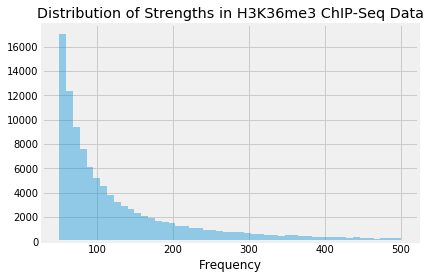

In [4]:
# Show strength distribution. What makes sense as a good cutoff?
chip_weaker = chip[chip['strength'] < 500]
fig = sns.distplot(chip_weaker['strength'], kde=False)
plt.xlabel('ChIP Signal Strength')
plt.xlabel('Frequency')
plt.title('Distribution of Strengths in H3K36me3 ChIP-Seq Data')
plt.savefig('chip_cutoff.png')

In [5]:
# Import formatted mm10 FOCS promoter list
promoters = pd.read_csv("/data2/josh/ep/focs_promoters_mm10.bed6",
            sep='\t', 
            header=None, 
            names=['chr','pos','pos2','gene','score','strand']
           )
promoters.head()

,chr,pos,pos2,gene,score,strand
0,chr1,3671723,3671723,Xkr4,4638,.
1,chr1,3671794,3671794,Xkr4,2432,.
2,chr1,4360242,4360242,Rp1,413,.
3,chr1,4360264,4360264,Rp1,4733,.
4,chr1,4409235,4409235,Rp1,371,.


In [6]:
# Label promoters as ChIP-seq overlapping or not (new column)
promoters_chip_list = [None] * promoters.shape[0]
for idx, row in promoters.iterrows():
    chrom = row.chr[3:]
    pos = row.pos
    chip_matches = chip[(chip['chr'] == chrom) & (chip['start']-50 < pos) & (chip['end']+50 > pos)]
    if chip_matches.empty:
        promoters_chip_list[idx] = False
    else:
        promoters_chip_list[idx] = True

promoters['chip'] = ''
promoters['chip'] = promoters_chip_list
# promoters['chip'] = [t[pos] > peaks['start'] for t in promoters]

In [7]:
promoters.to_csv('labeled_promoters_chip1.bed',sep='\t',index=True, header=True)

In [8]:
promoters[promoters['chip'] == True].shape

(2851, 7)

In [9]:
# Import TAD list
tads = pd.read_csv('/data2/josh/tads/TAD_mm10.csv', delimiter='\t')
tads.head()

,chrom,start,end
0,chr10,99635000,100285000
1,chr10,96115000,97315000
2,chr10,97345000,97700000
3,chr10,90060000,90695000
4,chr10,26360000,26915000


In [11]:
# Label promoters with TADs
promoters_tad_list = [None] * promoters.shape[0]
for idx, row in promoters.iterrows():
    chrom = row.chr
    pos = row.pos
    tad_matches = tads[(tads['chrom'] == chrom) & (tads['start'] < pos) & (tads['end'] > pos)]
    if tad_matches.empty:
        promoters_tad_list[idx] = -1
    else:
        promoters_tad_list[idx] = tad_matches.index

promoters['tad'] = ''
promoters['tad'] = promoters_tad_list